In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import random

In [2]:
torch.manual_seed(42)
np.random.seed(42)

sampling_seed = 78
torch.manual_seed(sampling_seed)

training_data = np.loadtxt('TrainingData.txt', delimiter=' ')

In [3]:
input_nn = torch.tensor(training_data[:,0:2]).type(torch.float32)
output_nn = torch.tensor(training_data[:,2]).type(torch.float32).reshape(-1,1)
extr_input = [[torch.mean(input_nn[:,0]), torch.mean(input_nn[:,1])],[torch.std(input_nn[:,0]), torch.std(input_nn[:,1])]]
extr_output = [torch.mean(output_nn), torch.std(output_nn)]

input_nn[:,0] = (input_nn[:,0] - torch.mean(input_nn[:,0]))/(torch.std(input_nn[:,0]))
input_nn[:,1] = (input_nn[:,1] - torch.mean(input_nn[:,1]))/(torch.std(input_nn[:,1]))
output_nn = (output_nn - torch.mean(output_nn))/(torch.std(output_nn))


In [4]:
class NeuralNet(nn.Module):
    
    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

In [8]:
def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(0 * x_.shape[0] / 100)
    #training_size = x_.shape[0] - validation_size
    valid_index = random.sample(range(x_.shape[0]), validation_size)

    x_val = x_[valid_index, :]
    y_val = y_[valid_index, :]

    def th_delete(tensor, indices):
        mask = torch.ones(tensor.shape[0], dtype=torch.bool)
        mask[indices] = False
        return tensor[mask,:]

    x_train = th_delete(x_, valid_index)
    y_train = th_delete(y_, valid_index)

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    if opt_type == "ADAM1":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.002)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    #y_test_pred = my_network(x_test).reshape(-1, )
    y_val_pred = my_network(x_val).reshape(-1, )
    y_train_pred = my_network(x_train).reshape(-1, )

    # Compute the relative training error
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

    # Compute the relative validation error
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")

    return relative_error_train.item(), relative_error_val.item(), my_network

In [9]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

In [ ]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [30],
        "regularization_exp": [2],
        "regularization_param": [0, 1e-4],
        "batch_size": [5],
        "epochs": [1500],
        "optimizer": ["ADAM"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [3000],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

train_err_conf = list()
val_err_conf = list()
my_nets = list()

for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network = run_single_configuration(setup_properties, input_nn, output_nn)
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)
    my_nets.append(my_network)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)
my_nets = np.array(my_nets)
    

CHOOSE INDEX OK

In [8]:
choose=[0, 2, 7, 12, 14, 18, 25, 31, 32]


In [10]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [30],
        "regularization_exp": [2],
        "regularization_param": [0],
        "batch_size": [10],
        "epochs": [3500],
        "optimizer": ["ADAM"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [3000],
        "activation": ["tanh"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network_secondo = run_single_configuration(setup_properties, input_nn, output_nn)

################################### 0 ###################################
{'hidden_layers': 2, 'neurons': 30, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 10, 'epochs': 3500, 'optimizer': 'ADAM', 'init_weight_seed': 3000, 'activation': 'tanh'}
Final Training Loss:  1.339e-05
Final Validation Loss:  nan
Relative Training Error:  0.7949029095470905 %
Relative Validation Error:  nan %


In [12]:
hyperparameters_configurations = {
        "hidden_layers": [2],  
        "neurons": [25],  
        "regularization_exp": [2],  
        "regularization_param": [0],  
        "batch_size": [10],  
        "epochs": [3000],  
        "optimizer": ["ADAM1"], ###use LB but then you need to correct the batch size  
        "init_weight_seed": [128],  
        "activation": ["sigmoid"]
    }

settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network_maina = run_single_configuration(setup_properties, input_nn, output_nn)

################################### 0 ###################################
{'hidden_layers': 2, 'neurons': 25, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 10, 'epochs': 3000, 'optimizer': 'ADAM1', 'init_weight_seed': 128, 'activation': 'sigmoid'}
Final Training Loss:  6.629e-05
Final Validation Loss:  nan
Relative Training Error:  2.0044438540935516 %
Relative Validation Error:  nan %


FIT THE CHOSEN NN

In [7]:
hyperparameters_configurations = {
        "hidden_layers": [2],
        "neurons": [30],
        "regularization_exp": [2],
        "regularization_param": [0],
        "batch_size": [10],
        "epochs": [3500],
        "optimizer": ["ADAM"], ###use LB but then you need to correct the batch size
        "init_weight_seed": [3000],
        "activation": ["tanh"]
    }


settings = list(itertools.product(*hyperparameters_configurations.values()))

i = 0

for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7],
        "activation": setup[8]
    }

    relative_error_train_, relative_error_val_, my_network = run_single_configuration(setup_properties, input_nn, output_nn)

################################### 0 ###################################
{'hidden_layers': 2, 'neurons': 30, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 10, 'epochs': 3500, 'optimizer': 'ADAM', 'init_weight_seed': 3000, 'activation': 'tanh'}
Final Training Loss:  1.339e-05
Final Validation Loss:  nan
Relative Training Error:  0.7949029095470905 %
Relative Validation Error:  nan %


DEFINE THE COST FUNCTION

In [13]:
def values(my_network, n_sample, v_val, CF_ref = 0.45):
    results = []
    D_val = torch.from_numpy(np.linspace(2, 20, n_sample)).type(torch.float32).reshape(-1,1)
    D_val = (D_val - extr_input[0][0])/(extr_input[1][0] - extr_input[0][0])
    for j, i in enumerate(D_val):
        if j%50 == 0:
            print('#####################################', j, '#####################################')
        D_exp = (i.reshape(-1,1)).expand(v_val.shape[0], 1)
        input = torch.cat([D_exp, v_val], 1)
        pred = my_network(input).reshape(-1,1)
        input[:,0] = input[:,0]*(extr_input[1][0] - extr_input[0][0]) + extr_input[0][0]
        input[:,1] = input[:,1]*(extr_input[1][1] - extr_input[0][1]) + extr_input[0][1]
        ress = torch.cat([input, abs((pred*(extr_output[1]-extr_output[0]) + extr_output[0]) - CF_ref)], 1)
        ress = ress.tolist()
        sort = sorted(ress, key=lambda x: x[2])
        results = results + [sort[0]]
    return results

In [ ]:
def values_grid(my_network, n_sample, v_val, CF_ref = 0.45):
    results = []
    D_val = torch.from_numpy(np.linspace(2, 20, n_sample)).type(torch.float32).reshape(-1,1)
    D_val = (D_val - extr_input[0][0])/(extr_input[1][0] - extr_input[0][0])
    for j, i in enumerate(D_val):
        if j%50 == 0:
            print('#####################################', j, '#####################################')
        D_exp = (i.reshape(-1,1)).expand(v_val.shape[0], 1)
        input = torch.cat([D_exp, v_val], 1)
        pred = my_network(input).reshape(-1,1)
        input[:,0] = input[:,0]*(extr_input[1][0] - extr_input[0][0]) + extr_input[0][0]
        input[:,1] = input[:,1]*(extr_input[1][1] - extr_input[0][1]) + extr_input[0][1]
        ress = torch.cat([input, abs((pred*(extr_output[1]-extr_output[0]) + extr_output[0]) - CF_ref)], 1)
        ress = ress.tolist()
        results = results + ress
    return results

ENSEMBLE

In [ ]:
n_sample = 1000
v_val =  torch.from_numpy(np.linspace(50, 400, 1000*n_sample)).type(torch.float32).reshape(-1,1)
v_val = (v_val - extr_input[0][1])/(extr_input[1][1] - extr_input[0][1])

results_mean = []
for i in choose:
    results_1perD = values(my_nets[i], n_sample, v_val)
    results_mean.append(results_1perD)

results_secondo = values(my_network_secondo, n_sample, v_val)
results_mean.append(results_secondo)

In [15]:
results_mean = np.array(results_mean)

In [16]:
mean_res = np.zeros(1000)
for i in range(len(results_mean)):
    mean_res = mean_res + results_mean[i,:,1]
mean_res = mean_res/(len(choose)+1)

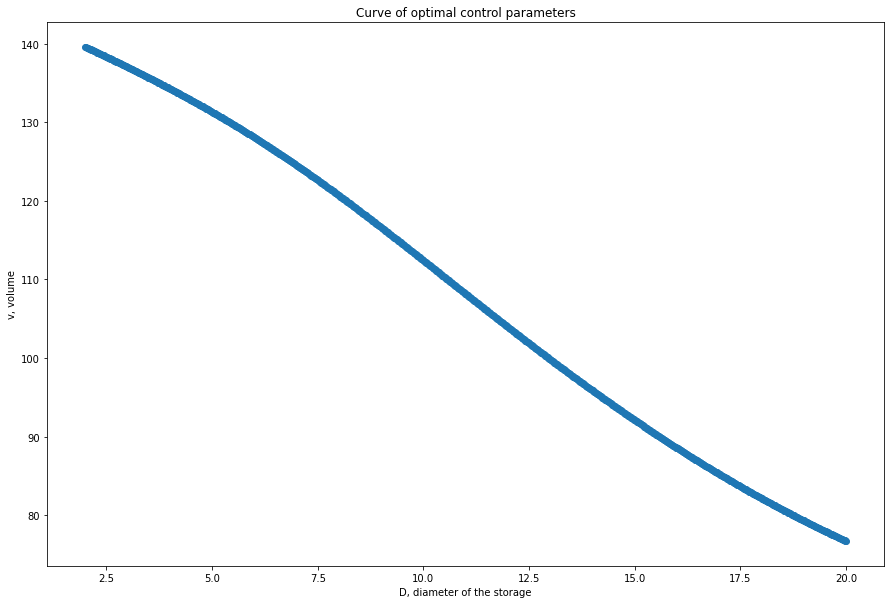

In [17]:
plt.figure(figsize=(15, 10))
plt.scatter(results_mean[3,:,0], mean_res)
plt.title("Curve of optimal control parameters")
plt.xlabel("D, diameter of the storage")
plt.ylabel("v, volume")
plt.show()

In [18]:
submission = np.concatenate([results_mean[1,:,0].reshape(-1,1), mean_res.reshape(-1,1)], 1)

LOSS FUNCTION !!! INSTEAD OF OPTIMIZING WITH A GRID

In [13]:
def argmin(G, y_0, lr=None, epochs=1000, verbose=False, box_constraint=None):
    y_opt = y_0.clone().detach().requires_grad_(True)

    if box_constraint is not None:
        if lr is None:
            lr = 0.01

        # ADAM can also be used here
        optimizer = optim.SGD([y_opt], lr=lr)

        for _ in range(epochs):

            def closure():
                optimizer.zero_grad()
                g_forward = G(y_opt)
                if verbose:
                    print("loss: ", g_forward.item(), "value :", y_opt)
                g_forward.backward()
                return g_forward

            optimizer.step(closure=closure)
            # TODO: implement Mirror descent with Bit entropy as Bregman divergence
            # For now, only projected gradient decent is implemented
            with torch.no_grad():
                y_opt.clamp_(*box_constraint)

    else:
        if lr is None:
            lr = 0.1
        optimizer = optim.LBFGS(
            [y_opt],
            lr=float(lr),
            max_iter=50000,
            max_eval=50000,
            history_size=100,
            line_search_fn="strong_wolfe",
            tolerance_change=1.0 * np.finfo(float).eps,
        )

        def closure():
            optimizer.zero_grad()
            g_forward = G(y_opt)
            if verbose:
                print("loss: ", g_forward.item(), "value :", y_opt)
            g_forward.backward()
            return g_forward

        optimizer.step(closure=closure)

    return y_opt.detach()

In [14]:
def get_G(approx_CF, CF_ref=0.45):
    def G(Dv):
        # sum to make it work with simultaneously on many rows
        return torch.sum((CF_ref - approx_CF(Dv)) ** 2)

    return G

In [15]:
CF_ref_ = 0.45
CF_ref = (CF_ref_ - extr_output[0])/(extr_output[1]- extr_output[0])

G = get_G(my_network, CF_ref=CF_ref)

In [16]:
D = torch.tensor([2, 20])
v = torch.tensor([50, 400])

n_samples = 1000
soboleng = torch.quasirandom.SobolEngine(dimension=2)
x_sample = soboleng.draw(n_samples)
#transform Sobol points
x_sample[:,0]=x_sample[:,0]*(D[1]-D[0])+D[0]
x_sample[:,1]=x_sample[:,1]*(v[1]-v[0])+v[0]

x_sample[:,0] = (x_sample[:,0] - extr_input[0][0])/(extr_input[1][0] - extr_input[0][0])
x_sample[:,1] = (x_sample[:,1] - extr_input[0][1])/(extr_input[1][1] - extr_input[0][1])

x_opt_curve = x_sample.clone().detach()
x_opt_curve = argmin(G, y_0=x_opt_curve, verbose=False, box_constraint=[0, 1])

In [17]:
x_opt_curve[:,0] = x_opt_curve[:,0]*(extr_input[1][0] - extr_input[0][0]) + extr_input[0][0]
x_opt_curve[:,1] = x_opt_curve[:,1]*(extr_input[1][1] - extr_input[0][1]) + extr_input[0][1]

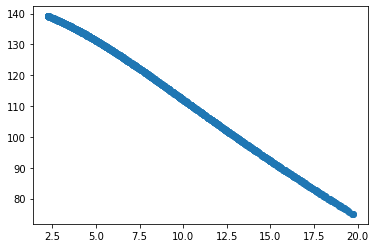

In [18]:
plt.scatter(x_opt_curve[:,0], x_opt_curve[:,1])